#Preprocesing dataset

In [2]:
!pip install XlsxWriter

     |████████████████████████████████| 149 kB 13.1 MB/s 


In [97]:
import numpy as np 
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import xlsxwriter
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import string
import unicodedata
import nltk
from keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional
import pandas as pd

In [4]:
alay_dict = pd.read_csv('data/slang_word_list.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

In [5]:
def remove_url(str):
    str = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', str)
    return str
    
def remove_digit(str):
    str = re.sub(r'[^a-z ]*([.0-9])*\d', ' ', str)
    return str 

def remove_non_ascii(str):
    str = unicodedata.normalize('NFKD', str).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return str

def remove_twitter_char(str):  
    # mention
    str = re.sub(r'(?:@[\w_]+)', ' ', str)
    # hashtag
    str = re.sub(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", " ", str)
    # RT/cc
    str = re.sub('RT', ' ', str)

    return str

def remove_punctuation(str):
    str = re.sub(r'[^\s\w]', ' ', str)
    return str

def remove_multi_space(str):
    str = re.sub('[\s]+', ' ', str)
    return str

def casefolding(str):  
    str = str.lower()   
    return ' '.join(str.split())

def remove_repeated_character(str):
    str = re.sub(r'(.)\1{2,}', r'\1', str)
    return str

# def normalize_slang_word(str):
#     text_list = str.split(' ')
#     slang_words_raw = pd.read_csv('data/slang_word_list.csv', sep="," , header=None)
#     slang_word_dict = {}

#     for item in slang_words_raw.values:
#         slang_word_dict[item[0]] = item[1]

#         for index in range(len(text_list)):
#             if text_list[index] in slang_word_dict.keys():
#                 text_list[index] = slang_word_dict[text_list[index]]

#     return ' '.join(text_list)


def normalize_slang_word(str):
    alay_dict = pd.read_csv('data/slang_word_list.csv', encoding='latin-1', header=None)
    alay_dict = alay_dict.rename(columns={0: 'original', 1: 'replacement'})
    alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in str.split(' ')])

# def remove_stopword(str):
#     id_stopword_dict = pd.read_csv('data/stopwordbahasa.csv', header=None)
#     id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})
#     str = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in str.split(' ')])
#     str = re.sub('  +', ' ', str)
#     str = str.strip()
#     return str

def remove_laugh(str):
    str = re.sub(r"\b(?:(h|a|e)*(?:(ha|he|hue))+h?|(?:l+o+)+l+)|(?:(w|k)*(?:wk)+(w?|k?))\b", ' ', str)
    
    return str

def remove_unused_char(str):
    tmp = ""    
    if len(str) < 3:
        tmp
    else:
        tmp = str
        
    return tmp

In [6]:
def preprocessing(str):
    str = remove_url(str)
    str = remove_twitter_char(str)
    str = remove_digit(str)
    str = remove_non_ascii(str)
    str = remove_punctuation(str)
    str = remove_laugh(str)
    str = remove_multi_space(str) 
    str = remove_repeated_character(str)    
    str = casefolding(str)
    str = normalize_slang_word(str)
    # str = remove_stopword(str)
    str = remove_unused_char(str)
    
    return str

In [7]:
kalimat = "@sabistriming: 3x Episode ini ada @frizareihan yang bakal cerita tentang pengalaman ngerinya nih! Simaaaaak! Gw menyesal setelah terjatuh https://t.co/bLhzV4Tqdl .. \xf0\x9f\x91\x8d"
preprocessing(kalimat)

'x episode ini ada yang bakal cerita tentang pengalaman ngerinya nih simak gue menyesal setelah terjatuh'

In [8]:
# data1 = pd.read_csv('dataset/train_preprocess1.csv', on_bad_lines='skip', encoding='latin-1')
data1 = pd.read_excel("dataset/train_preprocess1.xlsx")
# print(data1)
# data1['sentence'] = data1['sentence'].apply(preprocessing)

sentence = data1['sentence']
label = data1['label']

workbook = xlsxwriter.Workbook('dataset_clean/train_preprocess.xlsx')
worksheet = workbook.add_worksheet()

row = 0
col = 0

rowHeaders = ['sentence', 'label']
worksheet.write_row(row, col,  tuple(rowHeaders))

for i in sentence:
    sentence = preprocessing(i)
    rowValues = [sentence]
    row += 1
    worksheet.write_row(row, col, tuple(rowValues))

row = 0
for l in label:
    label = l
    rowValues = [label]
    row += 1 
    worksheet.write_row(row, col + 1, tuple(rowValues))

workbook.close()

# data3 = pd.read_csv("dataset/test_preprocess_masked_label.csv", on_bad_lines='skip', encoding='latin-1')
# data3['sentence'] = data3['sentence'].apply(preprocessing)

In [9]:
data2 = pd.read_excel("dataset/valid_preprocess1.xlsx")

sentence = data2['sentence']
label = data2['label']

workbook = xlsxwriter.Workbook('dataset_clean/valid_preprocess.xlsx')
worksheet = workbook.add_worksheet()

row = 0
col = 0

rowHeaders = ['sentence', 'label']
worksheet.write_row(row, col,  tuple(rowHeaders))

for i in sentence:
    sentence = preprocessing(i)
    rowValues = [sentence]
    row += 1
    worksheet.write_row(row, col, tuple(rowValues))

row = 0
for l in label:
    label = l
    rowValues = [label]
    row += 1 
    worksheet.write_row(row, col + 1, tuple(rowValues))

workbook.close()

In [11]:
data3 = pd.read_excel("dataset/test_preprocess_masked_label1.xlsx")

sentence = data3['sentence']
label = data3['label']

workbook = xlsxwriter.Workbook('dataset_clean/test_preprocess_masked_label.xlsx')
worksheet = workbook.add_worksheet()

row = 0
col = 0

rowHeaders = ['sentence', 'label']
worksheet.write_row(row, col,  tuple(rowHeaders))

for i in sentence:
    sentence = preprocessing(i)
    rowValues = [sentence]
    row += 1
    worksheet.write_row(row, col, tuple(rowValues))

row = 0
for l in label:
    label = l
    rowValues = [label]
    row += 1 
    worksheet.write_row(row, col + 1, tuple(rowValues))

workbook.close()

In [17]:
read_file = pd.read_excel ("dataset_clean/test_preprocess_masked_label.xlsx")
read_file.to_csv ("dataset_clean/test_preprocess_masked_label.csv", index = None, header=True)

readF = pd.read_csv("dataset_clean/test_preprocess_masked_label.csv", on_bad_lines='skip', encoding='latin-1')
print(readF)

                                              sentence  label
0    kemarin gue datang ke tempat makan baru yang a...      0
1    kayak nya sih gue tidak akan mau balik lagi ke...      0
2    kalau dipikir pikir sebenarnya tidak ada yang ...      0
3    ini pertama kalinya gue ke bank buat mengurus ...      0
4    waktu sampai dengan gue pernah disuruh ibu lat...      0
..                                                 ...    ...
495  kata nya tidur yang baik itu minimal enam jam ...      0
496                    indonesia itu ada di benua asia      0
497  salah satu kegemaran anak remaja indonesia sek...      0
498  melihat warna hijau bisa bikin mata jadi lebih...      0
499  bondan winarno yang suka bilang maknyus sekara...      0

[500 rows x 2 columns]


In [18]:
read_file = pd.read_excel ("dataset_clean/train_preprocess.xlsx")
read_file.to_csv ("dataset_clean/train_preprocess1.csv", index = None, header=True)

readF = pd.read_csv("dataset_clean/train_preprocess1.csv", on_bad_lines='skip', encoding='latin-1')
print(readF)

                                                sentence  label
0      warung ini dimiliki oleh pengusaha pabrik tahu...      1
1      mohon ulama lurus dan k mmbri hujjah partai ap...      0
2      lokasi strategis di jalan sumatra bandung temp...      1
3      betapa bahagia nya diri ini saat unboxing pake...      1
4      aduh jadi mahasiswa jangan sombong dong kasih ...     -1
...                                                  ...    ...
10992                                       tidak kecewa      1
10993  enak rasa masakan nya apalagi kepiting yang me...      1
10994        hormati partai partai yang telah berkoalisi      0
10995  pagi pagi di tol pasteur sudah macet parah bik...     -1
10996  meskipun sering belanja ke yogyakarta di riau ...      1

[10997 rows x 2 columns]


In [19]:
read_file = pd.read_excel ("dataset_clean/valid_preprocess.xlsx")
read_file.to_csv ("dataset_clean/valid_preprocess1.csv", index = None, header=True)

readF = pd.read_csv("dataset_clean/valid_preprocess1.csv", on_bad_lines='skip', encoding='latin-1')
print(readF)

                                               sentence  label
0     meski masa kampanye sudah selesai bukan berart...      0
1                                            tidak enak     -1
2     restoran ini menawarkan makanan sunda kami mem...      1
3     lokasi di alun alun masakan padang ini cukup t...      1
4     betapa bejat kader gerindra yang anggota dewan...     -1
...                                                 ...    ...
1255  film tncfu tidak cocok untuk penonton yang tid...     -1
1256  indihome ini mahal lah bayar nya nya penangana...     -1
1257  be deh gea cowok cupu yang takut dengan pacar ...     -1
1258  valen yang sangat tidak berkualitas konentator...     -1
1259  restoran ini menjadi tempat pilihan saya berbu...      1

[1260 rows x 2 columns]


#Train Model

In [27]:
data_train = pd.read_csv("dataset_clean/train_preprocess1.csv", on_bad_lines='skip', encoding='latin-1')
data_train.head()

,sentence,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,1
1,mohon ulama lurus dan k mmbri hujjah partai ap...,0
2,lokasi strategis di jalan sumatra bandung temp...,1
3,betapa bahagia nya diri ini saat unboxing pake...,1
4,aduh jadi mahasiswa jangan sombong dong kasih ...,-1


In [28]:
data_test = pd.read_csv("dataset_clean/test_preprocess_masked_label.csv", on_bad_lines='skip', encoding='latin-1')
data_test.head()

,sentence,label
0,kemarin gue datang ke tempat makan baru yang a...,0
1,kayak nya sih gue tidak akan mau balik lagi ke...,0
2,kalau dipikir pikir sebenarnya tidak ada yang ...,0
3,ini pertama kalinya gue ke bank buat mengurus ...,0
4,waktu sampai dengan gue pernah disuruh ibu lat...,0


In [34]:
sentence_train = data_train.loc[:,'sentence']
training_sentences = sentence_train.values.tolist()

label_train = data_train.loc[:,'label']
training_label = label_train.values.tolist()

sentence_test = data_test.loc[:,'sentence']
test_sentences = sentence_train.values.tolist()

label_test = data_test.loc[:,'label']
test_label = label_test.values.tolist()

In [71]:
maxlen = max([len(i.split()) for i in sentence_train])
print(maxlen)

85


In [75]:
def fit_tokenizer(training_sentences):
        
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words = 10000, oov_token = "<OOV>")
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(training_sentences)
        
    return tokenizer

def seq_pad_and_trunc(sentences, tokenizer):
           
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, maxlen=300, padding='post', truncating='post')
        
    return pad_trunc_sequences

In [81]:
tokenizer = fit_tokenizer(training_sentences)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

train_pad_trunc_seq = seq_pad_and_trunc(training_sentences, tokenizer)
test_pad_trunc_seq = seq_pad_and_trunc(test_sentences, tokenizer)

training_label = np.array(training_label)
test_label = np.array(test_label)

Vocabulary contains 15652 words

<OOV> token included in vocabulary

index of word 'i' should be 793


####Model

#####BLSTM

In [83]:
embedding_dim = 16

model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, embedding_dim, input_length=100),
    tf.keras.layers.Bidirectional(LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model2 = tf.keras.Sequential([
#     tf.keras.layers.Embedding(VOCAB_SIZE, embedding_dim, input_length=max_length),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
#     tf.keras.layers.Dense(dense_dim, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model3 = tf.keras.Sequential([
#     tf.keras.layers.Embedding(VOCAB_SIZE, embedding_dim, input_length=max_length),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
#     tf.keras.layers.Dense(dense_dim, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model4 = tf.keras.Sequential([
#     tf.keras.layers.Embedding(VOCAB_SIZE, embedding_dim, input_length=max_length),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
#     tf.keras.layers.Dense(dense_dim, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model5 = tf.keras.Sequential([
#     tf.keras.layers.Embedding(VOCAB_SIZE, embedding_dim, input_length=max_length),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
#     tf.keras.layers.Dense(dense_dim, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [85]:
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model1.summary()

num_epochs = 10
batch_size = 128

# history_lstm = model1.fit(training_padded, training_label, batch_size=batch_size, epochs=num_epochs, validation_data=(testing_padded, test_label))
history_lstm = model1.fit(train_pad_trunc_seq, training_label, batch_size=batch_size, epochs=num_epochs, validation_data=(test_pad_trunc_seq, test_label))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           250432    
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 24)                1560      
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 264,561
Trainable params: 264,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
86/86 [==============================] - ETA: 0s - loss: -0.2323 - accuracy: 0.2977

ValueError: ignored

Total Data : 10997
Positive : 6410
Neutral : 1150
Negative : 3437


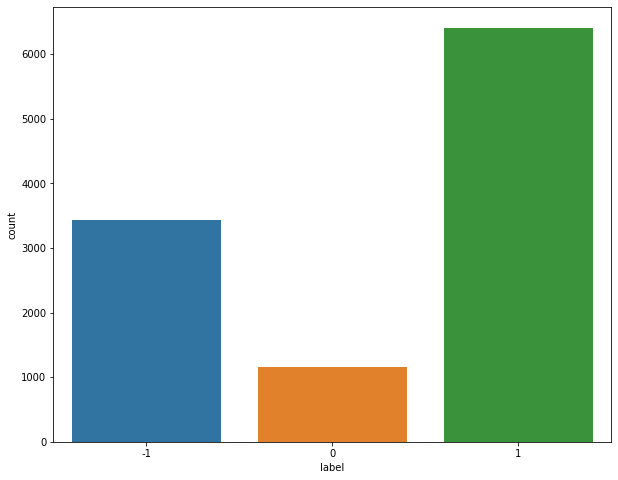

In [87]:
data = pd.read_excel("dataset_clean/train_preprocess.xlsx")
data.replace('', np.nan, inplace=True)
data.dropna(inplace=True) # memastikan tidak ada nilai yang kosong
positive = data.loc[data['label'] == 1, 'sentence'].copy().reset_index(drop=True)
neutral = data.loc[data['label'] == 0, 'sentence'].copy().reset_index(drop=True)
negative = data.loc[data['label'] == -1, 'sentence'].copy().reset_index(drop=True)
print("Total Data :", len(data))
print("Positive :", len(positive))
print("Neutral :", len(neutral))
print("Negative :", len(negative))

plt.figure(figsize=(10,8))
sns.countplot(x='label', data=data)
plt.show()

In [92]:
# Splitting Data
text = data['sentence'].values
label = data['label'].values

data_train = text
label_train = label

data1 = pd.read_excel("dataset_clean/test_preprocess_masked_label.xlsx")
data1.replace('', np.nan, inplace=True)
data_test = data1['sentence'].values
label_test = data1['label'].values

data2 = pd.read_excel("dataset_clean/valid_preprocess.xlsx")
data2.replace('', np.nan, inplace=True)
data_val = data2['sentence'].values
label_val = data2['label'].values

['warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung tahu berkualitas dipadu keahlian memasak dipadu kretivitas jadilah warung yang menyajikan menu utama berbahan tahu ditambah menu umum lain seperti ayam semuanya selera indonesia rga cukup terjangkau jangan melewati tahu bletoka nya tidak kalah dengan yang asli dari tegal'
 'mohon ulama lurus dan k mmbri hujjah partai apa yang rus diwlh agar suara islam tidak pecah pecah'
 'lokasi strategis di jalan sumatra bandung tempat nya nyaman terutama sofa di lantai paella nya enak sangat pas dimakan dengan minum bir dingin appetiser nya juga enak enak'
 ... 'hormati partai partai yang telah berkoalisi'
 'pagi pagi di tol pasteur sudah macet parah bikin jengkel saja ini'
 'meskipun sering belanja ke yogyakarta di riau junction tapi baru pertama kali ini saya lihat foodlife tempat nya luas dan bersih tidak kumuh semacam foodcourt lainnya dan pilihan makanan nya banyak banget dari yang t

In [106]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

vocab = max([len(tokenizer.word_index)]) + 1 # kamus kata 
maxlen = max([len(i.split()) for i in text]) # panjang input sequence
batch_size = 128 # penentuan jumlah sample yang ditraining pada tiap epoch
num_epochs = 10 # banyak iterasi pada saat training model 
initializer = initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=2)

In [95]:
#Data Train
X_train = tokenizer.texts_to_sequences(data_train)
X_train = pad_sequences(X_train, maxlen=maxlen)
Y_train = to_categorical(label_train, num_classes = 3)

#Data Test
X_test = tokenizer.texts_to_sequences(data_test)
X_test = pad_sequences(X_test, maxlen=maxlen)
Y_test = to_categorical(label_test, num_classes = 3)

#Data Validation
X_val = tokenizer.texts_to_sequences(data_val)
X_val = pad_sequences(X_val, maxlen=maxlen)
Y_val = to_categorical(label_val, num_classes = 3)

In [100]:
def get_model1(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(Bidirectional(LSTM(128, recurrent_initializer = initializer, kernel_initializer = initializer)))
    model.add(Dense(3, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

def get_model2(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(Bidirectional(LSTM(128, recurrent_initializer = initializer, kernel_initializer = initializer, return_sequences=True)))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(3, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

def get_model3(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(Dropout(0.9))
    model.add(Bidirectional(LSTM(128, recurrent_initializer = initializer, kernel_initializer = initializer)))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

def get_model4(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(Dropout(0.9))
    model.add(Bidirectional(LSTM(128, recurrent_initializer = initializer, kernel_initializer = initializer, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

def plot_history(histories, key='loss'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.xlim([0,max(history.epoch)])
        
def evaluation(model, X, Y):
    # Predict the values
    Y_pred = model.predict(X)
    Y_pred_class = np.argmax(Y_pred, axis=1)
    Y_act = Y
    # accuracy
    accuracy = accuracy_score(Y_act, Y_pred_class)
    print("Accuracy: %.2f" % (accuracy*100), "%")
    # precision
    precision = precision_score(Y_act, Y_pred_class)
    print("Precision: %.2f" % (precision*100), "%")
    # recall
    recall = recall_score(Y_act, Y_pred_class)
    print("Recall: %.2f" % (recall*100), "%")
    
    return Y_act, Y_pred_class

def conf_matrix(Y_act, Y_pred):
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_act, Y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_mtx, annot=True, fmt="d");
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [107]:
model1 = get_model1(X_train, Y_train)
print()
history1 = model1.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 85, 128)           2003456   
                                                                 
 bidirectional_9 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 3)                 771       
                                                                 
Total params: 2,267,395
Trainable params: 2,267,395
Non-trainable params: 0
_________________________________________________________________
None

Epoch 1/10
86/86 [==============================] - 61s 664ms/step - loss: 0.4451 - accuracy: 0.6867 - val_loss: 0.3628 - val_accuracy: 0.7722
Epoch 2/10
86/86 [==============================] - 58s 675ms/step - loss: 0.3416 - accuracy:

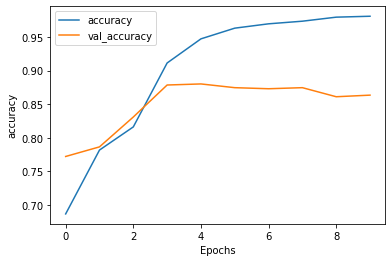

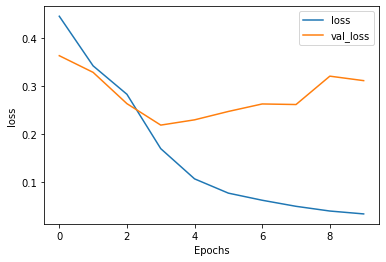

In [109]:
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history1, 'accuracy')
plot_graphs(history1, 'loss')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 85, 128)           2003456   
                                                                 
 bidirectional_10 (Bidirecti  (None, 85, 256)          263168    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 3)                 771       
                                                                 
Total params: 2,661,635
Trainable params: 2,661,635
Non-trainable params: 0
_________________________________________________________________
None

Epoch 1/10
86/86 [===================

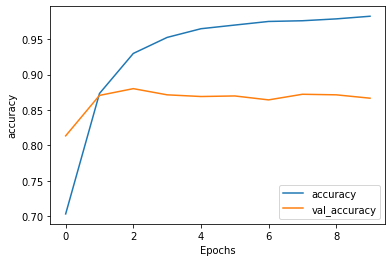

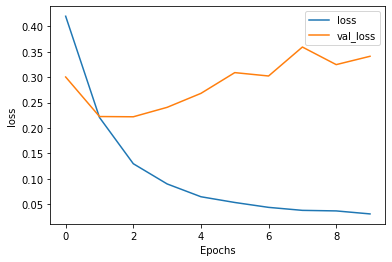

In [110]:
model2 = get_model2(X_train, Y_train)
print()
history2 = model2.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))
print()
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history2, 'accuracy')
plot_graphs(history2, 'loss')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 85, 128)           2003456   
                                                                 
 dropout (Dropout)           (None, 85, 128)           0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 256)              263168    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 3)                 771       
                                                                 
Total params: 2,267,395
Trainable params: 2,267,395
Non-trainable params: 0
___________________________________________

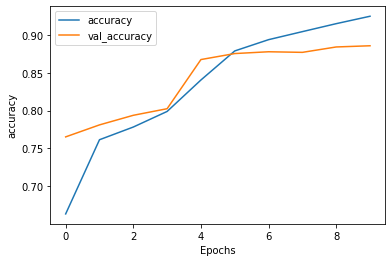

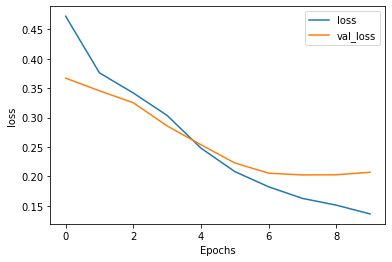

In [111]:
model3 = get_model3(X_train, Y_train)
print()
history3 = model3.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))
print()
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history3, 'accuracy')
plot_graphs(history3, 'loss')

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 85, 128)           2003456   
                                                                 
 dropout_2 (Dropout)         (None, 85, 128)           0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 85, 256)          263168    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 85, 256)           0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 256)             

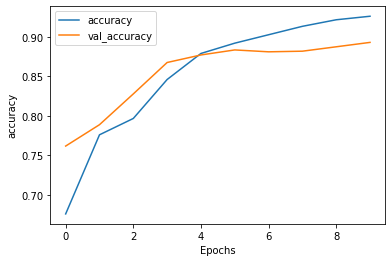

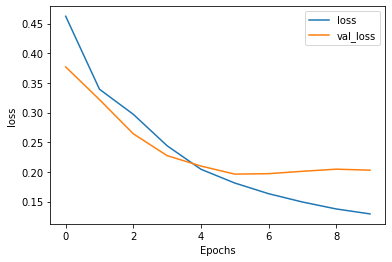

In [112]:
model4 = get_model4(X_train, Y_train)
print()
history4 = model4.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))
print()
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history4, 'accuracy')
plot_graphs(history4, 'loss')